## Imports



In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
#cobacoba

## Utilities



In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(20, 20))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

 

In [2]:
# Download the dataset
!wget https://raw.githubusercontent.com/kristianaryanto/CAPSTONE-PROJECT-GREEN/main/dataset/DKI2.csv
#!wget /home/yance/Capstone_Project/NewFolder/file1.csv
#import pandas as pd
#df = pd.read_csv("/home/yance/Capstone_Project/NewFolder/file1.csv")
#df.head
#!head file1.csv

--2022-05-23 19:19:54--  https://raw.githubusercontent.com/kristianaryanto/CAPSTONE-PROJECT-GREEN/main/dataset/DKI2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23584 (23K) [text/plain]
Saving to: ‘DKI2.csv’

DKI2.csv            100%[===================>]  23,03K  --.-KB/s    in 0,09s   

2022-05-23 19:19:57 (270 KB/s) - ‘DKI2.csv’ saved [23584/23584]



In [4]:
!head DKI1.csv

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical
0,2021-01-01,DKI1 (Bunderan HI),38,53,29,6,31,13,53,PM25
1,2021-01-02,DKI1 (Bunderan HI),27,46,27,7,47,7,47,O3
2,2021-01-03,DKI1 (Bunderan HI),44,58,25,7,40,13,58,PM25
3,2021-01-04,DKI1 (Bunderan HI),30,48,24,4,32,7,48,PM25
4,2021-01-05,DKI1 (Bunderan HI),38,53,24,6,31,9,53,PM25
5,2021-01-06,DKI1 (Bunderan HI),41,58,23,13,46,13,58,PM25
6,2021-01-07,DKI1 (Bunderan HI),35,47,22,6,39,10,47,PM25
7,2021-01-08,DKI1 (Bunderan HI),37,54,26,16,17,10,54,PM25
8,2021-01-09,DKI1 (Bunderan HI),47,61,16,27,22,12,61,PM25


For this lab and the next, you will only need the month number and the mean total sunspot number. You will load those into memory and convert it to arrays that represents a time series.

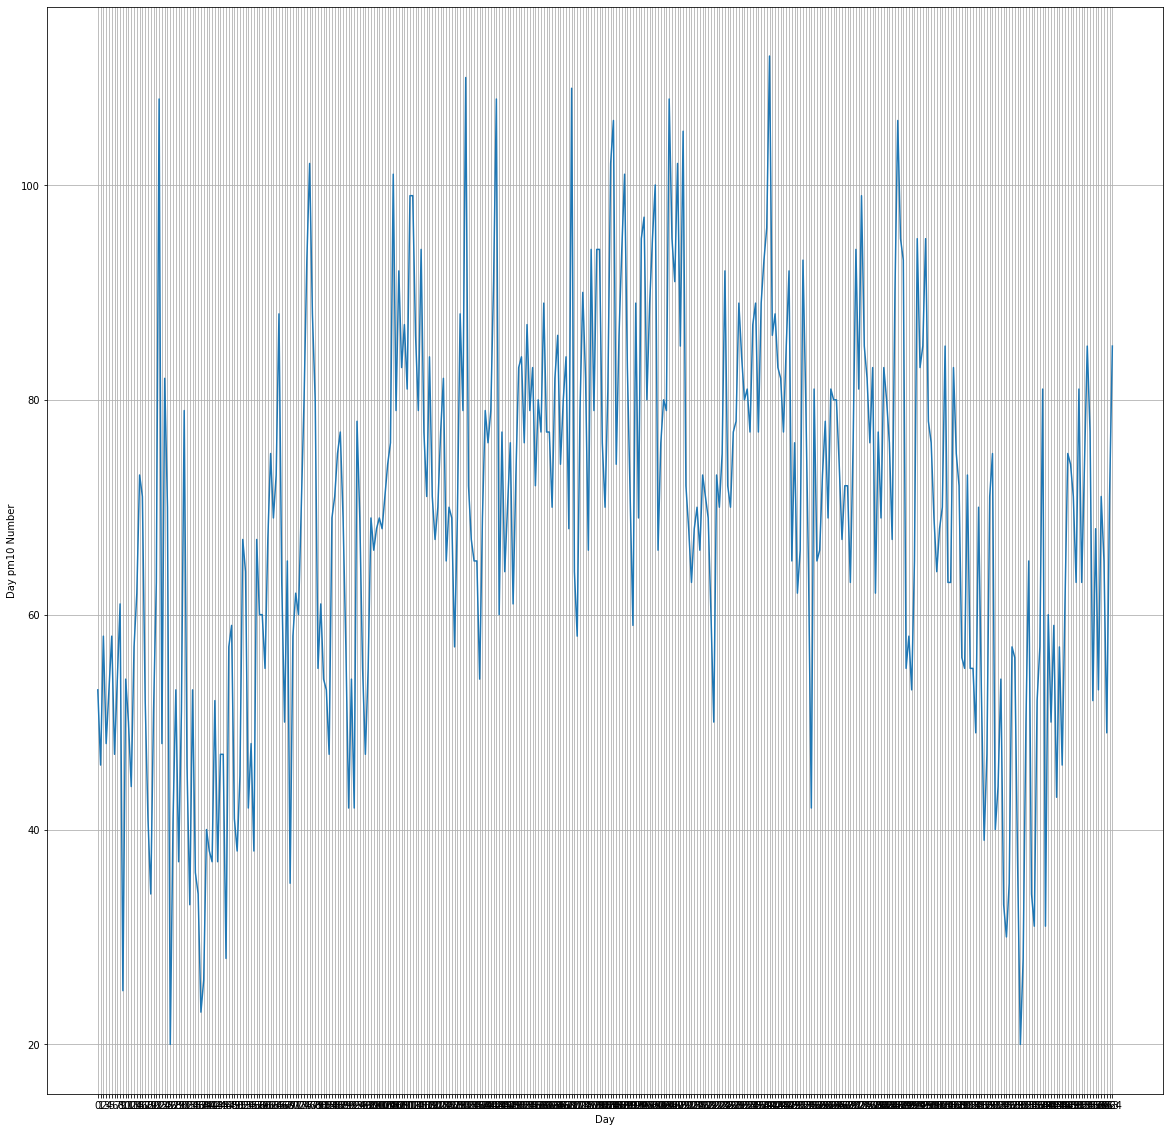

In [20]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./DKI1.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append((row[0]))
    sunspots.append(float(row[4]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='Day pm10 Number')

## Split the Dataset



In [6]:
# Define the split time
split_time = 300

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels



In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [8]:
# Parameters
window_size = 10
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2022-05-17 22:10:01.908793: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-17 22:10:01.908844: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-17 22:10:01.908883: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yance-pc): /proc/driver/nvidia/version does not exist
2022-05-17 22:10:01.909565: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-17 22:10:01.945145: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2294550000 Hz
2022-05-17 22:10:01.945637: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcc84000b60 initialized for platform Host (this does not guarantee that X

## Build the Model

The model will be 3-layer dense network as shown below.

In [9]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                330       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1984      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 85        
Total params: 5,007
Trainable params: 5,007
Non-trainable params: 0
_________________________________________________________________


## Tune the Learning Rate

You can pick a learning rate by running the same learning rate scheduler code from previous labs.

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 0s 5ms/step - loss: 71.4069 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 71.4069 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 71.4069 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 71.4069 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 71.4069 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 71.4069 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 71.4069 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 71.4069 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 0s 3ms/step - loss: 71.4069 - lr: 2.5119e-08
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 71.4069 - lr: 2.8184e-08
Epoch 11/100
10/10 

(1e-08, 0.001, 0.0, 100.0)

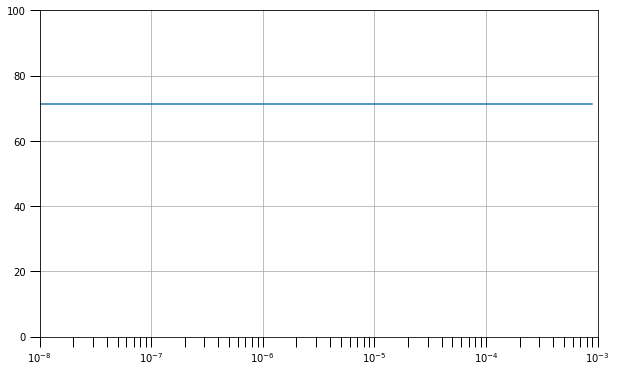

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Once you've picked a learning rate, you can rebuild the model and start training.

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [13]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 0s 3ms/step - loss: 87.8521 - mae: 88.3521 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 87.8104 - mae: 88.3104 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 87.7459 - mae: 88.2459 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 87.6675 - mae: 88.1675 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 87.5766 - mae: 88.0766 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 87.4748 - mae: 87.9748 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 87.3611 - mae: 87.8611 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 3ms/step - loss: 87.2359 - mae: 87.7359 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 87.0942 - mae: 87.5942 

## Model Prediction

Now see if the model generates good results. If you used the default parameters of this notebook, you should see the predictions follow the shape of the ground truth with an MAE of around 15. 

In [14]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

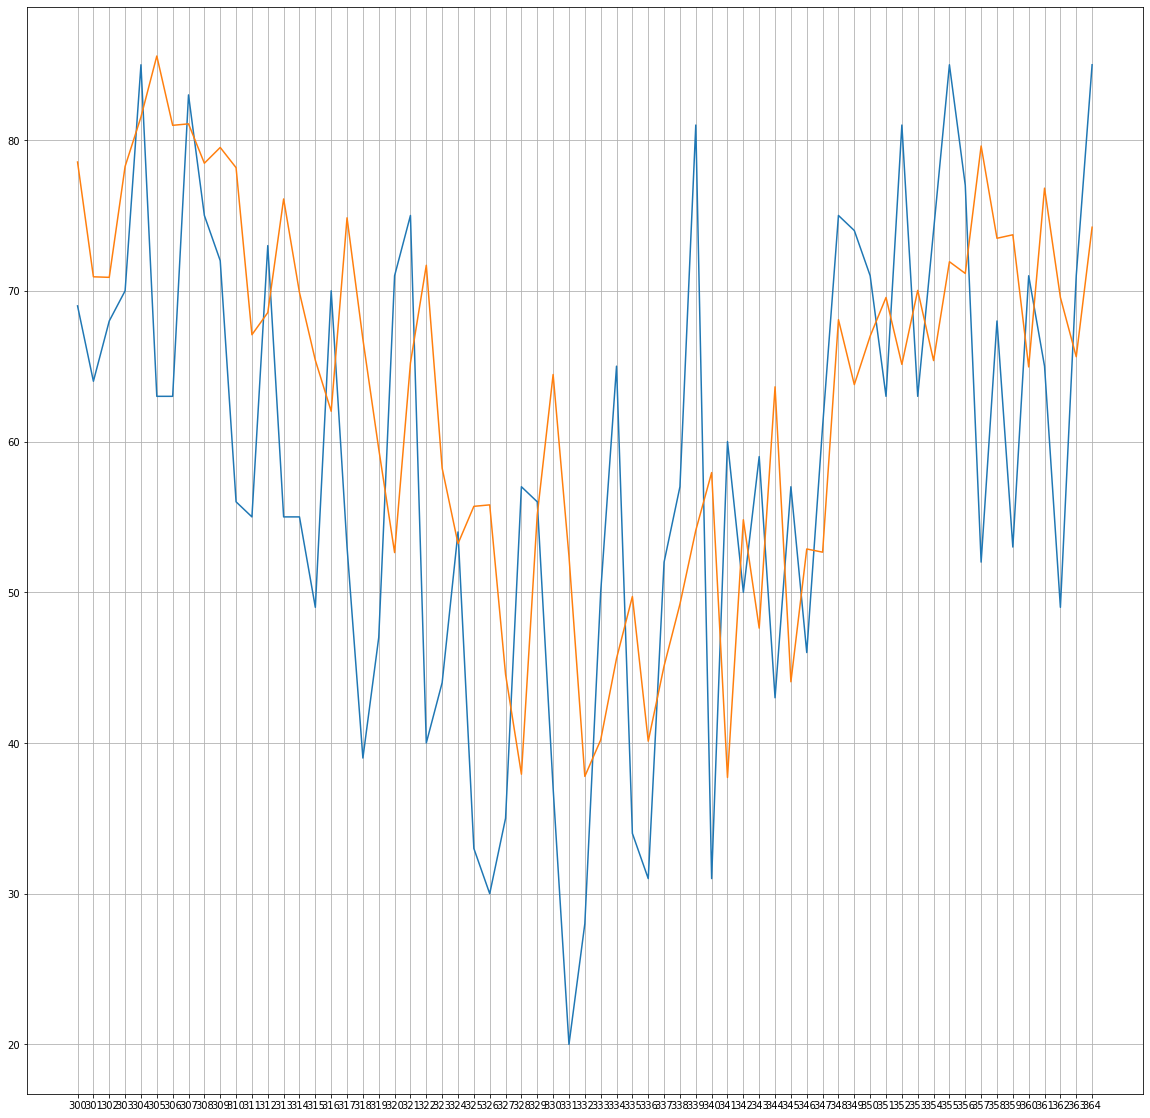

In [15]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [16]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

13.30118


In [17]:
import pandas as pd
df = pd.DataFrame(time_valid, columns = ['tanggal'])
df2 = pd.DataFrame(x_valid, columns = ['pm10'])
df = pd.concat ([df, df2],axis = 1)
#df = pd.DataFrame(df, ["tanggal, pm10"])
#pd.concat([df, df2], join_axes=[df.columns])

df = pd.DataFrame(df)
df

,tanggal,pm10
0,300,69.0
1,301,64.0
2,302,68.0
3,303,70.0
4,304,85.0
...,...,...
60,360,71.0
61,361,65.0
62,362,49.0
63,363,71.0


## Wrap Up

In this lab, you built a relatively simple DNN to forecast sunspot numbers for a given month. We encourage you to tweak the parameters or train longer and see the best results you can get. In the next lab, you will build a more complex model and you evaluate if the added complexity translates to better or worse results.